# Dry Conditions
 
 Highlights:
 
 - There has been little change in the mean and maximum number of consecutive dry days over the period 1951 to 2024.   

## Setup

First, we need to import all the necessary libraries. Some of them are specifically developed to handle the download and plotting of the data and are hosted at the [indicators set-up repository](https://github.com/lauracagigal/indicators_setup) in GitHub

In [1]:
import os
import os.path as op
import sys
import folium

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_int import plot_timeseries_interactive
from ind_setup.plotting import plot_bar_probs
from ind_setup.tables import plot_df_table, table_rain_dry_summary


sys.path.append("../../../functions")
from data_downloaders import GHCN
from rain_func import consecutive_dry_days, count_consecutive_days

In [2]:
country = 'Palau'
vars_interest = ['PRCP']

## Get Data

In [3]:
update_data = False
path_data = "../../../data"
path_figs = "../../../matrix_cc/figures"

In [4]:
if update_data:
    df_country = GHCN.get_country_code(country)
    print(f'The GHCN code for {country} is {df_country["Code"].values[0]}')

    df_stations = GHCN.download_stations_info()
    df_country_stations = df_stations[df_stations['ID'].str.startswith(df_country.Code.values[0])]
    print(f'There are {df_country_stations.shape[0]} stations in {country}')

## Observations from Koror Station

https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/doc/GHCND_documentation.pdf

The data used for this analysis comes from the GHCN (Global Historical Climatology Network)-Daily database. <br>
This a database that addresses the critical need for historical daily temperature, precipitation, and snow records over global land areas. GHCN-Daily is a
composite of climate records from numerous sources that were merged and then subjected to a suite of
quality assurance reviews. The archive includes over 40 meteorological elements including temperature daily maximum/minimum, temperature at observation time,
precipitation and more.

In [5]:
if update_data:
    GHCND_dir = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    id = 'PSW00040309' # Koror Station
    dict_prcp = GHCN.extract_dict_data_var(GHCND_dir, 'PRCP', df_country_stations.loc[df_country_stations['ID'] == id])[0]
    data = dict_prcp[0]['data']#.dropna()
    data.to_pickle(op.join(path_data, 'GHCN_precipitation.pkl'))
else:
    data = pd.read_pickle(op.join(path_data, 'GHCN_precipitation.pkl'))

Dry days are considered those in which precipitation is lower than 1mm. <br>

In [6]:
threshold = 1 #Threshold for dry and wet day
data = data.groupby(data.index.year).filter(lambda x: len(x) >= 300).dropna()
data['dry_day'] = np.where(data['PRCP'] < threshold, 1, 0)

In [7]:
consecutive_dry_year = data.groupby(data.index.year)['dry_day'].apply(consecutive_dry_days)
data['below_threshold'] = data['PRCP'] < threshold
data['consecutive_days'] = count_consecutive_days(data['below_threshold'])

The following plot represents the average number of dry days which are considered those in which precipitation is lower than 1mm. <br>

(<Figure size 1200x500 with 1 Axes>,
 <Axes: ylabel='Mean consecutive dry days [< 1mm]'>)

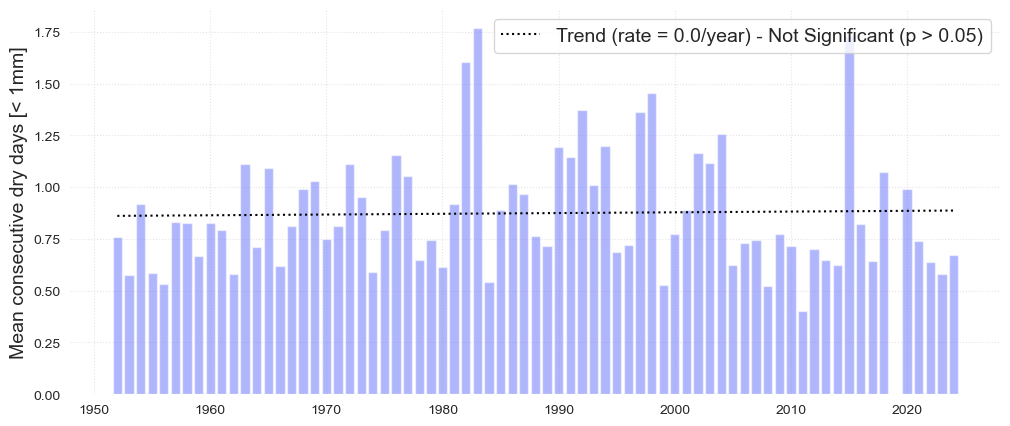

In [8]:
plot_bar_probs(np.unique(data.index.year), data.groupby(data.index.year)['consecutive_days'].mean(), 
               trendline =True, y_label = 'Mean consecutive dry days [< 1mm]',
               figsize = [12, 5])


The following plot represents the maximum number of dry days which are considered those in which precipitation is lower than 1mm. <br>

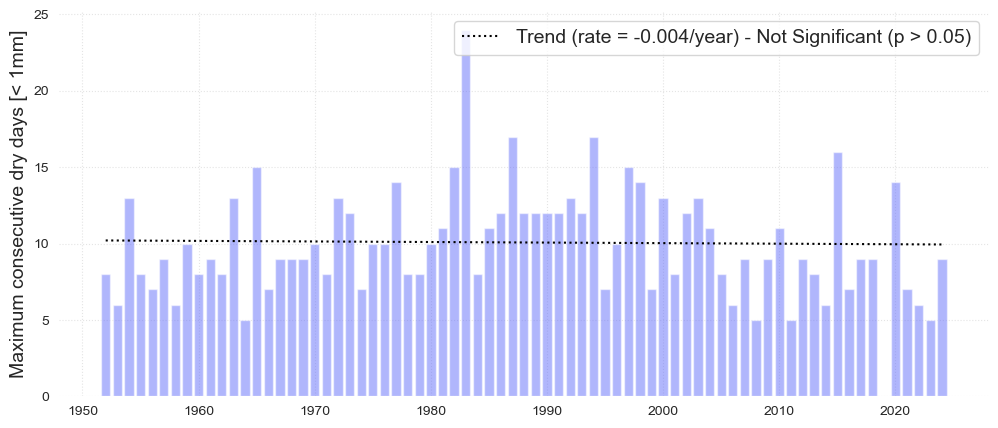

In [9]:
fig = plot_bar_probs(np.unique(data.index.year), data.groupby(data.index.year)['consecutive_days'].max(), 
               trendline =True, y_label = 'Maximum consecutive dry days [< 1mm]',
               figsize = [12, 5])

plt.savefig(op.join(path_figs, 'F6b_Consecutive_dry.png'), dpi=300, bbox_inches='tight')


### Generate table
Table sumarizing different metrics of the data analyzed in the plots above

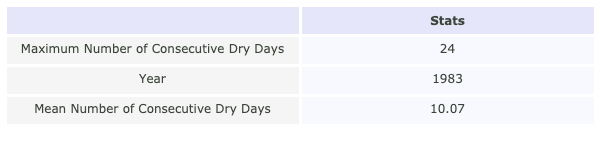

In [10]:
df = table_rain_dry_summary(data)
fig = plot_df_table(df.T, figsize = (600, 150),)